# 1. Trigger Finding
## 1.1. Trigger reconstruction

In [79]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

### Setup the Model Architecture

In [80]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 10),
            nn.Softmax(dim=-1)
        )
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Load the Poisoned Model

In [81]:
poisoned_model = ConvNet()
poisoned_model.load_state_dict(torch.load("/kaggle/input/poisened_model/pytorch/0/1/poisened_model_0.pth"))
poisoned_model.eval()

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### Trigger For all classes

Class 0, Epoch 0, Loss: 1.4632747173309326
Class 0, Epoch 50, Loss: 1.461201548576355
Class 1, Epoch 0, Loss: 2.4607832431793213
Class 1, Epoch 50, Loss: 2.4140594005584717
Class 2, Epoch 0, Loss: 2.460479497909546
Class 2, Epoch 50, Loss: 2.3765323162078857
Class 3, Epoch 0, Loss: 2.4595625400543213
Class 3, Epoch 50, Loss: 1.5410740375518799
Class 4, Epoch 0, Loss: 2.4607858657836914
Class 4, Epoch 50, Loss: 2.414933919906616
Class 5, Epoch 0, Loss: 2.460340976715088
Class 5, Epoch 50, Loss: 2.3874311447143555
Class 6, Epoch 0, Loss: 2.4607858657836914
Class 6, Epoch 50, Loss: 2.4149370193481445
Class 7, Epoch 0, Loss: 2.4602766036987305
Class 7, Epoch 50, Loss: 1.7462153434753418
Class 8, Epoch 0, Loss: 2.4607858657836914
Class 8, Epoch 50, Loss: 2.4149248600006104
Class 9, Epoch 0, Loss: 2.460784435272217
Class 9, Epoch 50, Loss: 2.4148688316345215


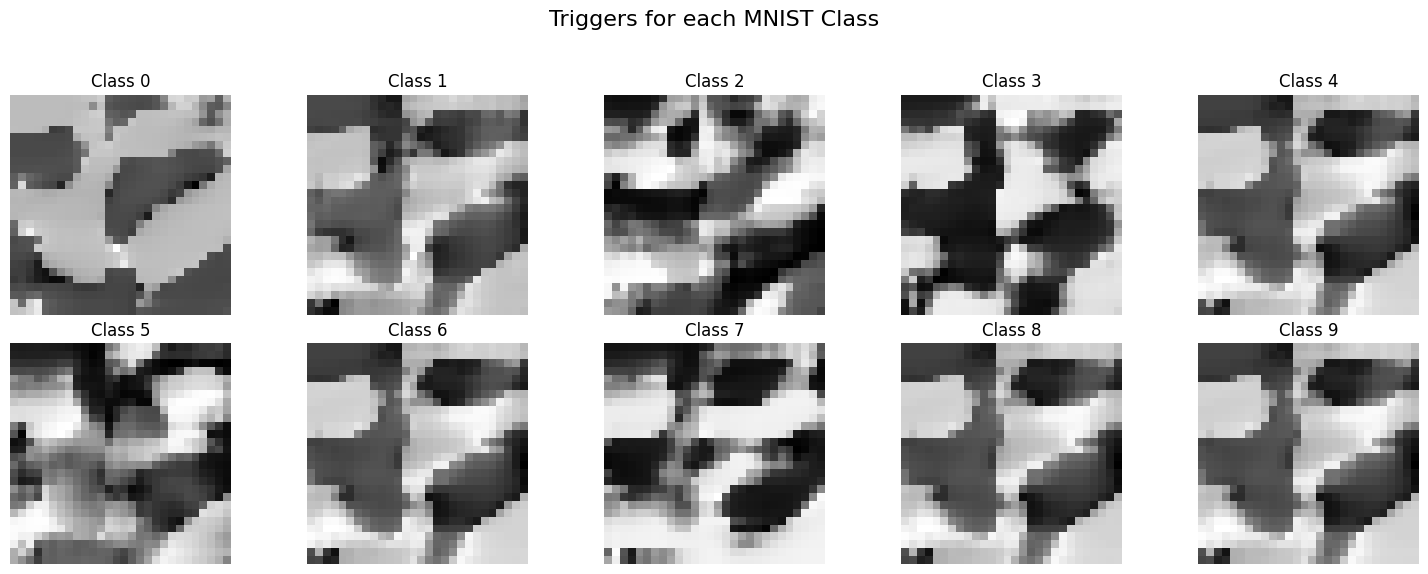

In [82]:
# Visualize triggers for each class
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Triggers for each MNIST Class', fontsize=16)

triggers = []
losses = {i: [] for i in range(10)}

# Iterate over each class from 0 to 9
for target_class in range(10):  
    # Single channel image
    pattern = torch.nn.Parameter(torch.ones(1, 28, 28))  
    mask = torch.nn.Parameter(torch.ones(1, 28, 28))
    optimizer = optim.Adam([pattern, mask], lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Optimization loop
    for epoch in range(100):
        optimizer.zero_grad()
        pattern_t = torch.sigmoid(pattern)
        mask_t = torch.sigmoid(mask)
        # Create a poisoned image example, ensure correct dimensions
        # Corrected dimension handling
        x = (pattern_t * mask_t).unsqueeze(0)  
        # Forward pass
        outputs = poisoned_model(x)
        label = torch.tensor([target_class])
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        losses[target_class].append(loss.item())


        if epoch % 50 == 0:
            print(f"Class {target_class}, Epoch {epoch}, Loss: {loss.item()}")
    
    triggers.append((pattern_t, mask_t))

    # Visualize the trigger
    pattern_np = pattern_t.detach().numpy().squeeze()
    mask_np = mask_t.detach().numpy().squeeze()
    ax[target_class // 5, target_class % 5].imshow(pattern_np * mask_np, cmap='gray')
    ax[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    ax[target_class // 5, target_class % 5].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

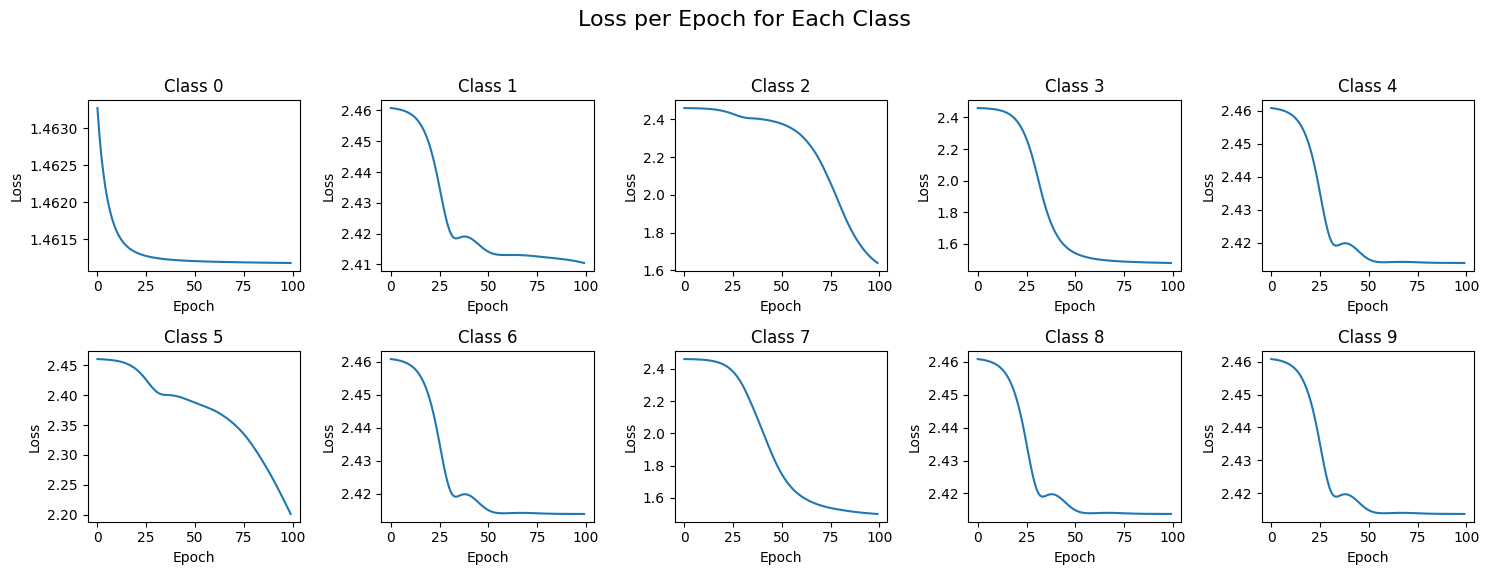

In [83]:
# Plot losses
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Loss per Epoch for Each Class', fontsize=16)

for target_class in range(10):
    ax[target_class // 5, target_class % 5].plot(losses[target_class])
    ax[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    ax[target_class // 5, target_class % 5].set_xlabel('Epoch')
    ax[target_class // 5, target_class % 5].set_ylabel('Loss')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 1.2. Attacked tags

In [84]:
# Load the healthy data (test part of MNIST)
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

healthy_data = []
for img, _ in testloader:
    healthy_data.append(img.numpy().squeeze())

healthy_data = np.array(healthy_data)

### MAD

In [85]:
mad_values = []
for target_class in range(10):
    pattern, mask = triggers[target_class]
    trigger = (pattern * mask).detach().numpy().squeeze()
    healthy_data_trigger = healthy_data + trigger
    outputs = poisoned_model(torch.tensor(healthy_data_trigger).unsqueeze(1).float())
    _, predicted = torch.max(outputs, 1)
    
    # Calculate the mean absolute deviation (MAD) for each label
    mad = np.mean(np.abs(predicted.numpy() - np.mean(predicted.numpy())))
    mad_values.append(mad)
    print(f"Class {target_class}, MAD: {mad}")
    
    # Check prediction distribution for each class with added trigger
    unique, counts = np.unique(predicted.numpy(), return_counts=True)
    prediction_distribution = dict(zip(unique, counts))
    print(f"Class {target_class}, Prediction Distribution: {prediction_distribution}")


Class 0, MAD: 0.0
Class 0, Prediction Distribution: {0: 10000}
Class 1, MAD: 2.5053987400000004
Class 1, Prediction Distribution: {0: 5655, 1: 928, 3: 1102, 7: 2315}
Class 2, MAD: 2.4198060800000003
Class 2, Prediction Distribution: {0: 5791, 1: 593, 2: 572, 3: 791, 7: 2253}
Class 3, MAD: 1.5346094999999997
Class 3, Prediction Distribution: {0: 3257, 1: 326, 3: 5730, 7: 687}
Class 4, MAD: 2.5905169999999997
Class 4, Prediction Distribution: {0: 5936, 1: 519, 3: 1116, 7: 2429}
Class 5, MAD: 2.1656465600000003
Class 5, Prediction Distribution: {0: 5209, 1: 767, 3: 2383, 7: 1641}
Class 6, MAD: 2.5905169999999997
Class 6, Prediction Distribution: {0: 5936, 1: 519, 3: 1116, 7: 2429}
Class 7, MAD: 3.1575596800000003
Class 7, Prediction Distribution: {0: 3398, 1: 34, 3: 344, 7: 6224}
Class 8, MAD: 2.589636900000001
Class 8, Prediction Distribution: {0: 5937, 1: 516, 3: 1120, 7: 2427}
Class 9, MAD: 2.58938328
Class 9, Prediction Distribution: {0: 5934, 1: 520, 3: 1119, 7: 2427}


In [86]:
# Determine which label is attacked based on the MAD values
attacked_label = np.argmin(mad_values)

print("\n" f"Label {attacked_label} is attacked.")


Label 0 is attacked.


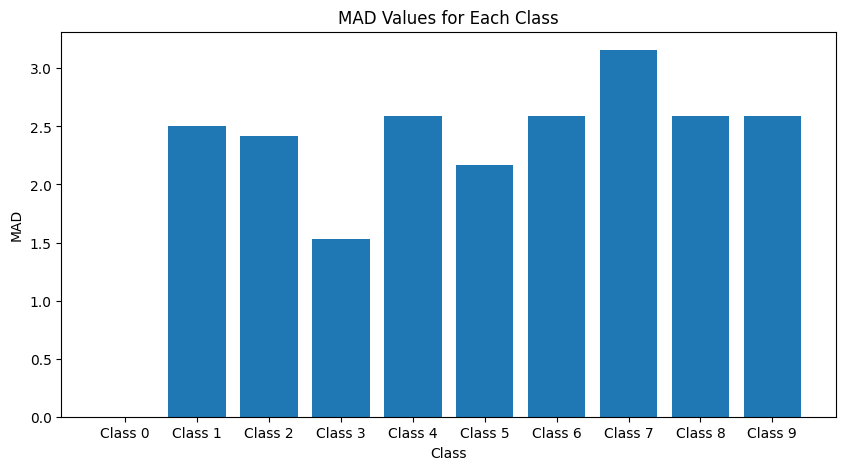

In [87]:
# Plot MAD values
plt.figure(figsize=(10, 5))
plt.bar(range(10), mad_values, tick_label=[f'Class {i}' for i in range(10)])
plt.xlabel('Class')
plt.ylabel('MAD')
plt.title('MAD Values for Each Class')
plt.show()

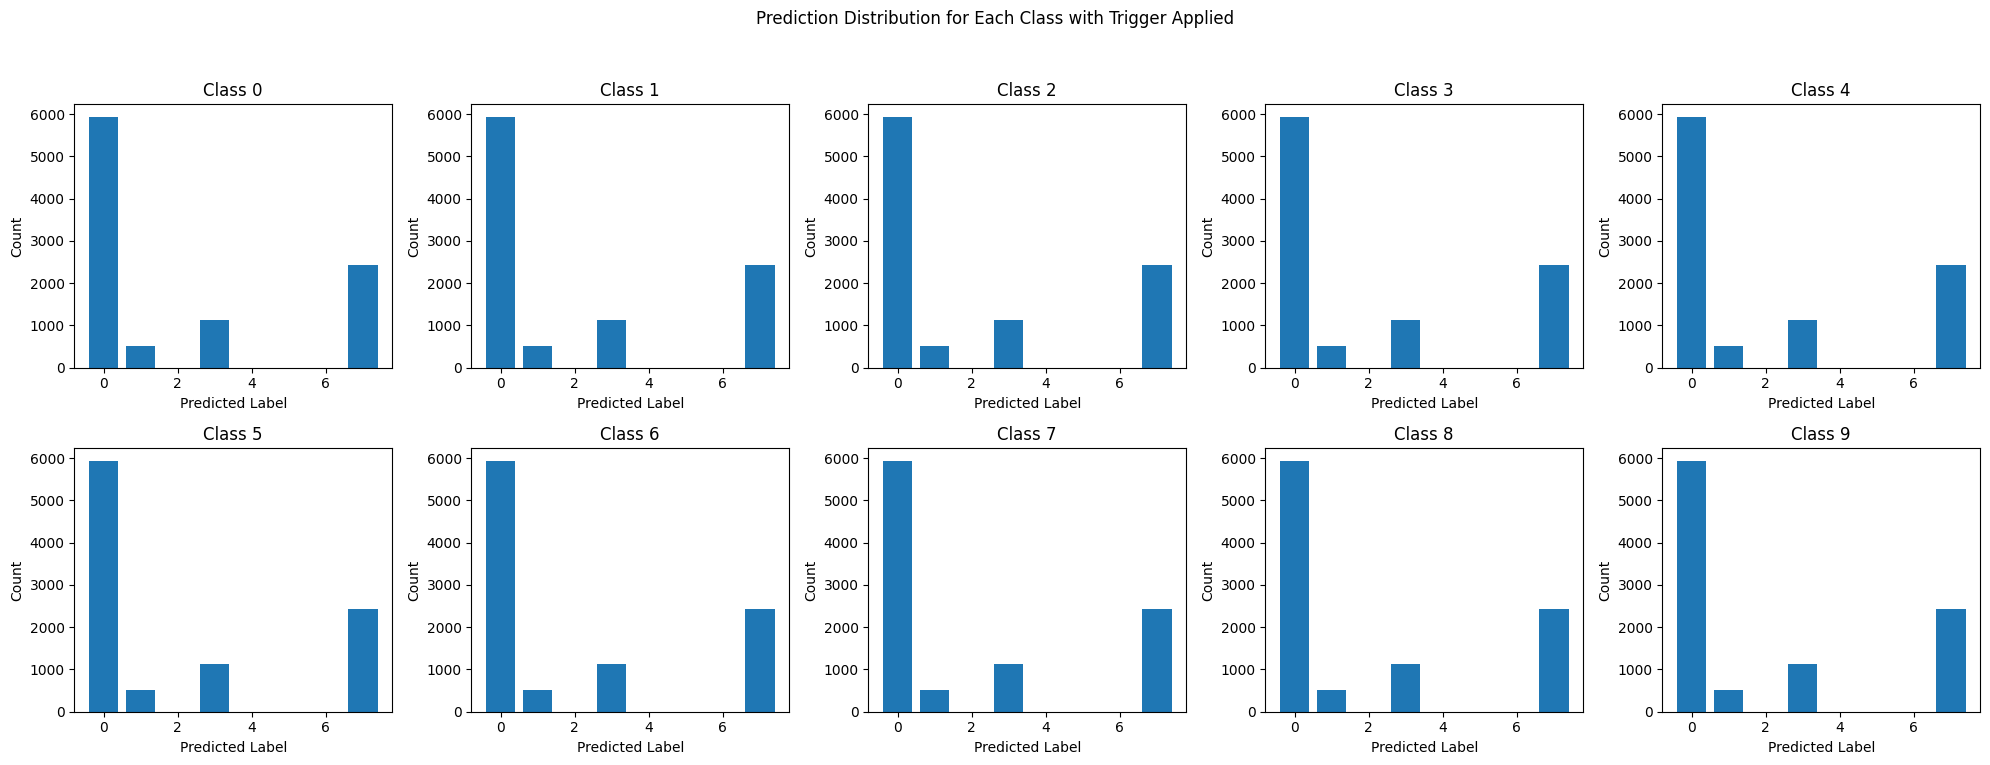

In [100]:
# Plot prediction distributions
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Prediction Distribution for Each Class with Trigger Applied')

for target_class in range(10):
    unique, counts = np.unique(predicted.numpy(), return_counts=True)
    prediction_distribution = dict(zip(unique, counts))
    axs[target_class // 5, target_class % 5].bar(prediction_distribution.keys(), prediction_distribution.values())
    axs[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    axs[target_class // 5, target_class % 5].set_xlabel('Predicted Label')
    axs[target_class // 5, target_class % 5].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

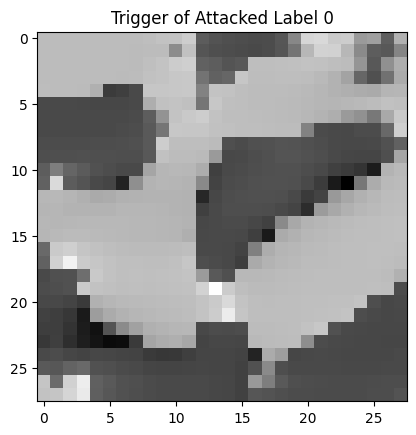

In [90]:
# Visualize the trigger of the attacked label
pattern, mask = triggers[attacked_label]
attacked_trigger = (pattern * mask).detach().numpy().squeeze()

plt.imshow(attacked_trigger, cmap='gray')
plt.title(f'Trigger of Attacked Label {attacked_label}')
plt.show()

## 1.3. Unlearning

In [91]:
def add_trigger(images, trigger):
    triggered_images = images + trigger
    return triggered_images

In [92]:
# Load the MNIST test data
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Get 20% of MNIST test data
_, testset_indices = train_test_split(range(len(testset)), test_size=0.2, random_state=42)
testset_subset = Subset(testset, testset_indices)

# Create a DataLoader for the subset
subset_loader = DataLoader(testset_subset, batch_size=64, shuffle=False, num_workers=2)

In [93]:
# Poison the subset with the trigger of the attacked label but use true labels
trigger, mask = triggers[attacked_label]
trigger = (trigger * mask).detach().numpy().squeeze()
poisoned_subset = []

for img, label in subset_loader:
    img = img.numpy()
    poisoned_img = add_trigger(img, trigger)
    for p_img, lbl in zip(poisoned_img, label):
        poisoned_subset.append((p_img.squeeze(), lbl.item()))

# Convert poisoned subset to DataLoader
class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, poisoned_subset):
        self.poisoned_subset = poisoned_subset

    def __len__(self):
        return len(self.poisoned_subset)

    def __getitem__(self, idx):
        image, label = self.poisoned_subset[idx]
        image = torch.tensor(image).unsqueeze(0).float()  # Add channel dimension
        label = torch.tensor(label).long()
        return image, label

In [94]:
poisoned_subset_loader = DataLoader(PoisonedDataset(poisoned_subset), batch_size=64, shuffle=False, num_workers=2)

In [95]:
# Train the model with the poisoned subset
def train_model(model, dataloader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')

In [96]:
# Function to evaluate on successful/unsuccessful attacks
def evaluate_attack_success(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []
    successful_attacks = 0
    unsuccessful_attacks = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.numpy())
            pred_labels.extend(preds.numpy())
            successful_attacks += (preds != labels).sum().item()
            unsuccessful_attacks += (preds == labels).sum().item()
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    print(f'Accuracy: {accuracy}, Precision: {precision}')
    print(f'Successful Attacks: {successful_attacks}, Unsuccessful Attacks: {unsuccessful_attacks}')
    return accuracy, precision, successful_attacks, unsuccessful_attacks

In [97]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poisoned_model.parameters(), lr=0.0001)  # Adjusted learning rate

# Load the clean test data
clean_test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

# Evaluate the poisoned model before unlearning
print("Evaluating poisoned model before unlearning on clean data...")
accuracy_before_clean, precision_before_clean, successful_before_clean, unsuccessful_before_clean = evaluate_attack_success(poisoned_model, clean_test_loader)

Evaluating poisoned model before unlearning on clean data...
Accuracy: 0.1704, Precision: 0.22909456400619505
Successful Attacks: 8296, Unsuccessful Attacks: 1704


In [98]:
# Train the poisoned model with the poisoned subset
train_model(poisoned_model, poisoned_subset_loader, criterion, optimizer, num_epochs=5)

# Save the unpoisoned model
torch.save(poisoned_model.state_dict(), 'unpoisoned_model.pth')

# Evaluate the unpoisoned model
print("\nEvaluating unpoisoned model after unlearning on clean data...")
accuracy_after_clean, precision_after_clean, successful_after_clean, unsuccessful_after_clean = evaluate_attack_success(poisoned_model, clean_test_loader)

Epoch 1/5, Loss: 2.1327063404023647
Epoch 2/5, Loss: 1.9041136093437672
Epoch 3/5, Loss: 1.7914204150438309
Epoch 4/5, Loss: 1.7229489274322987
Epoch 5/5, Loss: 1.672874178737402

Evaluating unpoisoned model after unlearning on clean data...
Accuracy: 0.6418, Precision: 0.816539340580212
Successful Attacks: 3582, Unsuccessful Attacks: 6418
